In [2]:
!pip install xgboost


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\Chulpan\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
import numpy as np
import pandas as pd


# df = pd.read_json('/kaggle/input/cars-rus-china/cars.json')
df = pd.read_json('cars.json')
df.head(5)

,Марка,Модель,Год выпуска,Цена,Двигатель,Мощность,Коробка передач,Привод,Тип кузова,Пробег,Цвет,Владельцы,Руль,Поколение,Комплектация,URL,Дата публикации
0,Hyundai,Palisade,2018.0,2 990 000 ₽,"дизель, 2.2 л","200 л.с., налог",автомат,4WD,None,78 728 км,белый,1,левый,1 поколение,None,https://auto.drom.ru/spb/hyundai/palisade/7835...,29.06.2025
1,Volvo,S40,2007.0,535 000 ₽,"бензин, 2.4 л","140 л.с., налог",АКПП,передний,None,214 927 км,золотистый,3,левый,2 поколение,None,https://auto.drom.ru/spb/volvo/s40/132815604.h...,29.06.2025
2,Honda,Clarity,2018.0,2 200 000 ₽,"бензин, 1.5 л, гибрид","103 л.с., налог",вариатор,передний,None,99 278 км,серый,1,левый,2 поколение,17 kWh Plug-In Hybrid,https://auto.drom.ru/spb/honda/fcx_clarity/553...,26.06.2025
3,Kia,Rio,2005.0,480 000 ₽,"бензин, 1.4 л","97 л.с., налог",АКПП,передний,седан,198 000 км,красный,4 и более,левый,2 поколение,None,https://auto.drom.ru/spb/kia/rio/136720884.htm...,23.06.2025
4,Nissan,X-Trail,2006.0,429 000 ₽,"бензин, 2.0 л","140 л.с., налог",механика,передний,None,287 000 км,серый,1,левый,"1 поколение, рестайлинг",2.0 MT 2WD Comfort,https://auto.drom.ru/spb/nissan/x-trail/365307...,25.06.2025


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2402 entries, 0 to 2401
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Марка            2393 non-null   object 
 1   Модель           2393 non-null   object 
 2   Год выпуска      2393 non-null   float64
 3   Цена             2393 non-null   object 
 4   Двигатель        2391 non-null   object 
 5   Мощность         2388 non-null   object 
 6   Коробка передач  2392 non-null   object 
 7   Привод           2393 non-null   object 
 8   Тип кузова       1276 non-null   object 
 9   Пробег           2379 non-null   object 
 10  Цвет             2359 non-null   object 
 11  Владельцы        2117 non-null   object 
 12  Руль             2373 non-null   object 
 13  Поколение        2288 non-null   object 
 14  Комплектация     1418 non-null   object 
 15  URL              2402 non-null   object 
 16  Дата публикации  2393 non-null   object 
dtypes: float64(1), obje

In [5]:
df = df.dropna(subset=["Марка", "Модель", "Год выпуска", "Цена", "Пробег", "Мощность"])

df["Тип кузова"] = df["Тип кузова"].fillna("не указано")
df["Комплектация"] = df["Комплектация"].fillna("не указано")
df["Владельцы"] = df["Владельцы"].fillna("не указано")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2374 entries, 0 to 2401
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Марка            2374 non-null   object 
 1   Модель           2374 non-null   object 
 2   Год выпуска      2374 non-null   float64
 3   Цена             2374 non-null   object 
 4   Двигатель        2374 non-null   object 
 5   Мощность         2374 non-null   object 
 6   Коробка передач  2373 non-null   object 
 7   Привод           2374 non-null   object 
 8   Тип кузова       2374 non-null   object 
 9   Пробег           2374 non-null   object 
 10  Цвет             2345 non-null   object 
 11  Владельцы        2374 non-null   object 
 12  Руль             2355 non-null   object 
 13  Поколение        2269 non-null   object 
 14  Комплектация     2374 non-null   object 
 15  URL              2374 non-null   object 
 16  Дата публикации  2374 non-null   object 
dtypes: float64(1), obje

In [7]:
def clean_price(price_str):
    """Преобразует '1 940 000 ₽' в 1940000"""
    if pd.isna(price_str):
        return np.nan
    cleaned = price_str.replace(" ", "").replace("\xa0", "").replace("₽", "")
    return int(cleaned)

def clean_mileage(mileage_str):
    """Преобразует пробег в числовое значение, обрабатывая различные форматы"""
    if pd.isna(mileage_str):
        return np.nan
    
    cleaned = ''.join(c for c in mileage_str if c.isdigit() or c == ',')
    cleaned = cleaned.replace(',', '')
    
    if not cleaned:
        return 0
    
    try:
        return int(cleaned)
    except ValueError:
        return np.nan

def clean_power(power_str):
    """Извлекает число из мощности"""
    if pd.isna(power_str):
        return np.nan
    
    import re
    match = re.search(r'(\d+)', power_str)
    if match:
        return int(match.group(1))
    return np.nan


df["Цена"] = df["Цена"].apply(clean_price)
df["Пробег"] = df["Пробег"].apply(clean_mileage)
df["Мощность"] = df["Мощность"].apply(clean_power)
df.head(5)

,Марка,Модель,Год выпуска,Цена,Двигатель,Мощность,Коробка передач,Привод,Тип кузова,Пробег,Цвет,Владельцы,Руль,Поколение,Комплектация,URL,Дата публикации
0,Hyundai,Palisade,2018.0,2990000,"дизель, 2.2 л",200,автомат,4WD,не указано,78728,белый,1,левый,1 поколение,не указано,https://auto.drom.ru/spb/hyundai/palisade/7835...,29.06.2025
1,Volvo,S40,2007.0,535000,"бензин, 2.4 л",140,АКПП,передний,не указано,214927,золотистый,3,левый,2 поколение,не указано,https://auto.drom.ru/spb/volvo/s40/132815604.h...,29.06.2025
2,Honda,Clarity,2018.0,2200000,"бензин, 1.5 л, гибрид",103,вариатор,передний,не указано,99278,серый,1,левый,2 поколение,17 kWh Plug-In Hybrid,https://auto.drom.ru/spb/honda/fcx_clarity/553...,26.06.2025
3,Kia,Rio,2005.0,480000,"бензин, 1.4 л",97,АКПП,передний,седан,198000,красный,4 и более,левый,2 поколение,не указано,https://auto.drom.ru/spb/kia/rio/136720884.htm...,23.06.2025
4,Nissan,X-Trail,2006.0,429000,"бензин, 2.0 л",140,механика,передний,не указано,287000,серый,1,левый,"1 поколение, рестайлинг",2.0 MT 2WD Comfort,https://auto.drom.ru/spb/nissan/x-trail/365307...,25.06.2025


In [8]:
df['Год выпуска'] = pd.to_numeric(df['Год выпуска'], errors='coerce').fillna(0).astype(int)
df.head()

,Марка,Модель,Год выпуска,Цена,Двигатель,Мощность,Коробка передач,Привод,Тип кузова,Пробег,Цвет,Владельцы,Руль,Поколение,Комплектация,URL,Дата публикации
0,Hyundai,Palisade,2018,2990000,"дизель, 2.2 л",200,автомат,4WD,не указано,78728,белый,1,левый,1 поколение,не указано,https://auto.drom.ru/spb/hyundai/palisade/7835...,29.06.2025
1,Volvo,S40,2007,535000,"бензин, 2.4 л",140,АКПП,передний,не указано,214927,золотистый,3,левый,2 поколение,не указано,https://auto.drom.ru/spb/volvo/s40/132815604.h...,29.06.2025
2,Honda,Clarity,2018,2200000,"бензин, 1.5 л, гибрид",103,вариатор,передний,не указано,99278,серый,1,левый,2 поколение,17 kWh Plug-In Hybrid,https://auto.drom.ru/spb/honda/fcx_clarity/553...,26.06.2025
3,Kia,Rio,2005,480000,"бензин, 1.4 л",97,АКПП,передний,седан,198000,красный,4 и более,левый,2 поколение,не указано,https://auto.drom.ru/spb/kia/rio/136720884.htm...,23.06.2025
4,Nissan,X-Trail,2006,429000,"бензин, 2.0 л",140,механика,передний,не указано,287000,серый,1,левый,"1 поколение, рестайлинг",2.0 MT 2WD Comfort,https://auto.drom.ru/spb/nissan/x-trail/365307...,25.06.2025


In [9]:
import numpy as np
import pandas as pd
import re

df["Возраст"] = 2025 - df["Год выпуска"]

df["Объем двигателя"] = np.nan
df["Тип топлива"] = np.nan

for idx, engine in df["Двигатель"].items():
    if pd.isna(engine) or engine == "None":
        continue
        
    parts = [p.strip() for p in str(engine).split(",")]
    
    if len(parts) == 2 and "л" in parts[1]:
        df.at[idx, "Объем двигателя"] = float(parts[1].replace(" л", ""))
        df.at[idx, "Тип топлива"] = parts[0]
    
    elif len(parts) == 2 and ("гибрид" in parts[1].lower() or "электро" in parts[1].lower()):
        df.at[idx, "Объем двигателя"] = float(parts[0].replace(" л", ""))
        df.at[idx, "Тип топлива"] = "гибрид" if "гибрид" in parts[1].lower() else "электро"
    
    elif "л" in engine:
        vol_part = engine.replace(" л", "")
        try:
            df.at[idx, "Объем двигателя"] = float(vol_part)
            df.at[idx, "Тип топлива"] = "не указано"
        except ValueError:
            pass
    
    elif "электро" in engine.lower():
        df.at[idx, "Тип топлива"] = "электро"

df["Тип КПП"] = df["Коробка передач"].str.extract(r"(АКПП|МКПП|вариатор|робот)", flags=re.IGNORECASE)
df.head(5)

C:\Users\Chulpan\AppData\Local\Temp\ipykernel_996\2110298437.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'дизель' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[idx, "Тип топлива"] = parts[0]


,Марка,Модель,Год выпуска,Цена,Двигатель,Мощность,Коробка передач,Привод,Тип кузова,Пробег,...,Владельцы,Руль,Поколение,Комплектация,URL,Дата публикации,Возраст,Объем двигателя,Тип топлива,Тип КПП
0,Hyundai,Palisade,2018,2990000,"дизель, 2.2 л",200,автомат,4WD,не указано,78728,...,1,левый,1 поколение,не указано,https://auto.drom.ru/spb/hyundai/palisade/7835...,29.06.2025,7,2.2,дизель,NaN
1,Volvo,S40,2007,535000,"бензин, 2.4 л",140,АКПП,передний,не указано,214927,...,3,левый,2 поколение,не указано,https://auto.drom.ru/spb/volvo/s40/132815604.h...,29.06.2025,18,2.4,бензин,АКПП
2,Honda,Clarity,2018,2200000,"бензин, 1.5 л, гибрид",103,вариатор,передний,не указано,99278,...,1,левый,2 поколение,17 kWh Plug-In Hybrid,https://auto.drom.ru/spb/honda/fcx_clarity/553...,26.06.2025,7,NaN,NaN,вариатор
3,Kia,Rio,2005,480000,"бензин, 1.4 л",97,АКПП,передний,седан,198000,...,4 и более,левый,2 поколение,не указано,https://auto.drom.ru/spb/kia/rio/136720884.htm...,23.06.2025,20,1.4,бензин,АКПП
4,Nissan,X-Trail,2006,429000,"бензин, 2.0 л",140,механика,передний,не указано,287000,...,1,левый,"1 поколение, рестайлинг",2.0 MT 2WD Comfort,https://auto.drom.ru/spb/nissan/x-trail/365307...,25.06.2025,19,2.0,бензин,NaN


In [10]:
df['Владельцы'] = df['Владельцы'].replace({
    '1': 1,
    '2': 2,
    '3': 3,
    '4 и более': 4,
    'не указано': -1,
    None: -1
}).astype(int)

df.head(5)

C:\Users\Chulpan\AppData\Local\Temp\ipykernel_996\70593641.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Владельцы'] = df['Владельцы'].replace({


,Марка,Модель,Год выпуска,Цена,Двигатель,Мощность,Коробка передач,Привод,Тип кузова,Пробег,...,Владельцы,Руль,Поколение,Комплектация,URL,Дата публикации,Возраст,Объем двигателя,Тип топлива,Тип КПП
0,Hyundai,Palisade,2018,2990000,"дизель, 2.2 л",200,автомат,4WD,не указано,78728,...,1,левый,1 поколение,не указано,https://auto.drom.ru/spb/hyundai/palisade/7835...,29.06.2025,7,2.2,дизель,NaN
1,Volvo,S40,2007,535000,"бензин, 2.4 л",140,АКПП,передний,не указано,214927,...,3,левый,2 поколение,не указано,https://auto.drom.ru/spb/volvo/s40/132815604.h...,29.06.2025,18,2.4,бензин,АКПП
2,Honda,Clarity,2018,2200000,"бензин, 1.5 л, гибрид",103,вариатор,передний,не указано,99278,...,1,левый,2 поколение,17 kWh Plug-In Hybrid,https://auto.drom.ru/spb/honda/fcx_clarity/553...,26.06.2025,7,NaN,NaN,вариатор
3,Kia,Rio,2005,480000,"бензин, 1.4 л",97,АКПП,передний,седан,198000,...,4,левый,2 поколение,не указано,https://auto.drom.ru/spb/kia/rio/136720884.htm...,23.06.2025,20,1.4,бензин,АКПП
4,Nissan,X-Trail,2006,429000,"бензин, 2.0 л",140,механика,передний,не указано,287000,...,1,левый,"1 поколение, рестайлинг",2.0 MT 2WD Comfort,https://auto.drom.ru/spb/nissan/x-trail/365307...,25.06.2025,19,2.0,бензин,NaN


In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

df['Владельцы'] = df['Владельцы'].fillna('не указано')
df['Комплектация'] = df['Комплектация'].fillna('не указано')

le_make = LabelEncoder()
le_model = LabelEncoder()
le_kompl = LabelEncoder()
df['Комплектация'] = le_kompl.fit_transform(df['Комплектация'])
df['Марка_код'] = le_make.fit_transform(df['Марка'])
df['Модель_код'] = le_model.fit_transform(df['Модель'])

cat_cols = ['Тип кузова', 'Привод', 'Тип КПП', 'Тип топлива', 'Руль', 'Цвет']
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

df['Поколение_номер'] = df['Поколение'].str.extract(r'(\d+)').fillna(0).astype(int)

df['Мощность/Объем'] = df['Мощность'] / df['Объем двигателя']

df['Новый'] = (df['Пробег'] < 1000).astype(int)
df.head()

,Марка,Модель,Год выпуска,Цена,Двигатель,Мощность,Коробка передач,Пробег,Владельцы,Поколение,...,Цвет_оранжевый,Цвет_розовый,Цвет_серебристый,Цвет_серый,Цвет_синий,Цвет_фиолетовый,Цвет_черный,Поколение_номер,Мощность/Объем,Новый
0,Hyundai,Palisade,2018,2990000,"дизель, 2.2 л",200,автомат,78728,1,1 поколение,...,False,False,False,False,False,False,False,1,90.909091,0
1,Volvo,S40,2007,535000,"бензин, 2.4 л",140,АКПП,214927,3,2 поколение,...,False,False,False,False,False,False,False,2,58.333333,0
2,Honda,Clarity,2018,2200000,"бензин, 1.5 л, гибрид",103,вариатор,99278,1,2 поколение,...,False,False,False,True,False,False,False,2,NaN,0
3,Kia,Rio,2005,480000,"бензин, 1.4 л",97,АКПП,198000,4,2 поколение,...,False,False,False,False,False,False,False,2,69.285714,0
4,Nissan,X-Trail,2006,429000,"бензин, 2.0 л",140,механика,287000,1,"1 поколение, рестайлинг",...,False,False,False,True,False,False,False,1,70.000000,0


In [12]:
from datetime import datetime

def preprocess_dates(df, date_col):
    df[date_col] = pd.to_datetime(df[date_col])
    
    df['год'] = df[date_col].dt.year
    df['месяц'] = df[date_col].dt.month
    df['день'] = df[date_col].dt.day
    df['день_недели'] = df[date_col].dt.dayofweek
    df['квартал'] = df[date_col].dt.quarter
    df['день_года'] = df[date_col].dt.dayofyear
    
    df['викенд'] = (df[date_col].dt.dayofweek >= 5).astype(int)
    df['сезон'] = (df[date_col].dt.month % 12 // 3 + 1)

    current_date = datetime.now()
    df['дней_с_публикации'] = (current_date - df[date_col]).dt.days
    
    return df.drop(columns=[date_col])

df = preprocess_dates(df, 'Дата публикации')
df.head(5)

C:\Users\Chulpan\AppData\Local\Temp\ipykernel_996\371095834.py:4: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[date_col] = pd.to_datetime(df[date_col])


,Марка,Модель,Год выпуска,Цена,Двигатель,Мощность,Коробка передач,Пробег,Владельцы,Поколение,...,Новый,год,месяц,день,день_недели,квартал,день_года,викенд,сезон,дней_с_публикации
0,Hyundai,Palisade,2018,2990000,"дизель, 2.2 л",200,автомат,78728,1,1 поколение,...,0,2025,6,29,6,2,180,1,3,11
1,Volvo,S40,2007,535000,"бензин, 2.4 л",140,АКПП,214927,3,2 поколение,...,0,2025,6,29,6,2,180,1,3,11
2,Honda,Clarity,2018,2200000,"бензин, 1.5 л, гибрид",103,вариатор,99278,1,2 поколение,...,0,2025,6,26,3,2,177,0,3,14
3,Kia,Rio,2005,480000,"бензин, 1.4 л",97,АКПП,198000,4,2 поколение,...,0,2025,6,23,0,2,174,0,3,17
4,Nissan,X-Trail,2006,429000,"бензин, 2.0 л",140,механика,287000,1,"1 поколение, рестайлинг",...,0,2025,6,25,2,2,176,0,3,15


In [13]:
df.columns

Index(['Марка', 'Модель', 'Год выпуска', 'Цена', 'Двигатель', 'Мощность',
       'Коробка передач', 'Пробег', 'Владельцы', 'Поколение', 'Комплектация',
       'URL', 'Возраст', 'Объем двигателя', 'Марка_код', 'Модель_код',
       'Тип кузова_джип/suv 5 дв.', 'Тип кузова_купе', 'Тип кузова_лифтбек',
       'Тип кузова_минивэн', 'Тип кузова_не указано', 'Тип кузова_открытый',
       'Тип кузова_седан', 'Тип кузова_универсал', 'Тип кузова_хэтчбек 3 дв.',
       'Тип кузова_хэтчбек 5 дв.', 'Привод_задний', 'Привод_передний',
       'Тип КПП_вариатор', 'Тип КПП_робот', 'Тип топлива_гибрид',
       'Тип топлива_дизель', 'Тип топлива_не указано', 'Руль_правый',
       'Цвет_белый', 'Цвет_бордовый', 'Цвет_голубой', 'Цвет_желтый',
       'Цвет_зеленый', 'Цвет_золотистый', 'Цвет_коричневый', 'Цвет_красный',
       'Цвет_оранжевый', 'Цвет_розовый', 'Цвет_серебристый', 'Цвет_серый',
       'Цвет_синий', 'Цвет_фиолетовый', 'Цвет_черный', 'Поколение_номер',
       'Мощность/Объем', 'Новый', 'год', '

In [14]:
features = ['Год выпуска', 'Мощность', 'Пробег', 'Владельцы', 'Комплектация',
       'Возраст', 'Объем двигателя', 'Марка_код', 'Модель_код',
       'Тип кузова_джип/suv 5 дв.', 'Тип кузова_купе', 'Тип кузова_лифтбек',
       'Тип кузова_минивэн', 'Тип кузова_не указано', 'Тип кузова_открытый',
       'Тип кузова_седан', 'Тип кузова_универсал', 'Тип кузова_хэтчбек 3 дв.',
       'Тип кузова_хэтчбек 5 дв.', 'Привод_задний', 'Привод_передний',
       'Тип КПП_вариатор', 'Тип КПП_робот', 'Тип топлива_гибрид',
       'Тип топлива_дизель', 'Тип топлива_не указано', 'Руль_правый',
       'Цвет_белый', 'Цвет_бордовый', 'Цвет_голубой', 'Цвет_желтый',
       'Цвет_зеленый', 'Цвет_золотистый', 'Цвет_коричневый', 'Цвет_красный',
       'Цвет_оранжевый', 'Цвет_розовый', 'Цвет_серебристый', 'Цвет_серый',
       'Цвет_синий', 'Цвет_фиолетовый', 'Цвет_черный', 'Поколение_номер',
        'Мощность/Объем', 'Новый', 'год', 'месяц', 'день', 'день_недели',
       'квартал', 'день_года', 'викенд', 'сезон', 'дней_с_публикации']

target = 'Цена'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

import joblib
joblib.dump(le_make, 'le_make.pkl')
joblib.dump(le_model, 'le_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (1899, 54)
Размер тестовой выборки: (475, 54)


In [18]:
df.to_csv('russia_cars.csv', index=False)


In [17]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

base_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"MAE: {mae:.2f} ₽")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f} ₽")
print(f"R² Score: {r2:.4f}")

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
import matplotlib.pyplot as plt

xgb.plot_importance(best_model)
plt.show()

NameError: name 'xgb' is not defined

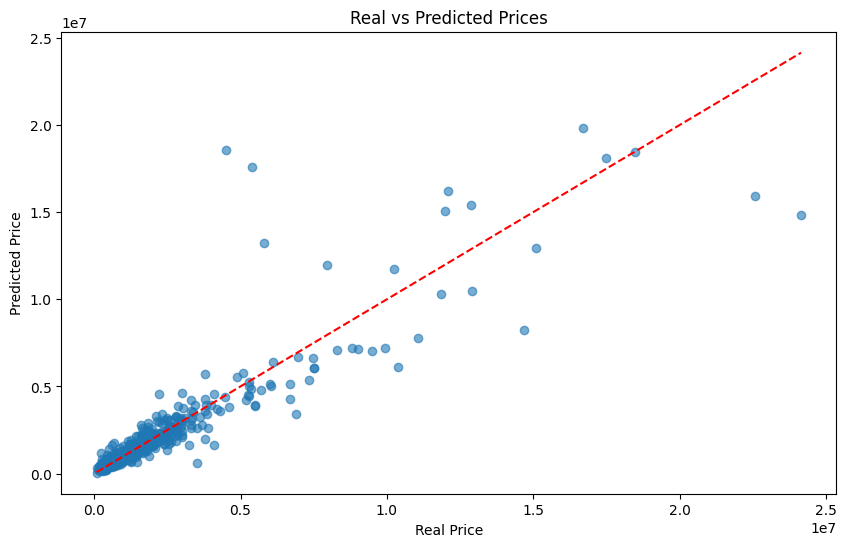

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Real Price')
plt.ylabel('Predicted Price')
plt.title('Real vs Predicted Prices')
plt.show()

In [ ]:
import pickle

with open("cars_best_model.pkl", "wb") as f:
    pickle.dump(grid_search, f)